## Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Many ML problems involve thousands or even millions of features for each training instance. Having more features make training extremly slow and make it much harder to find a good solution (Curse of Dimensionality).

To combat this, there are ways to reduce the number of features considerably, turning an intractable problem into a tractable one. E.g in the MNIST dataset,  image borders are almost always white, so you can drop those pixels. Additionally, two neighboring pixels are often highly correlated: if you merge the two pixels (taking the mean), you will not lose much information.

Dimensionality Reduction is also useful for data visualization (reducing the number of dimensions down to two (or three) makes it possible to plot a condesed view of high dimensional data on a graph to gain some important insights by visually detecting patterns, such as clusters.

Main Approaches: 

## Projection

Training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within a much lower-dimensional subspace of the high-dimensional space. For example, in the figure below, you see a 3D dataset represented by circles. 

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

X2D_using_svd = X2D

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [7]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [8]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

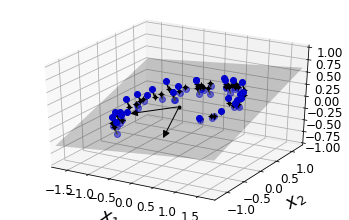

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.show()

If we porject every training instance perpendicularly onto this subspace, we get the new 2D dataset shown below:

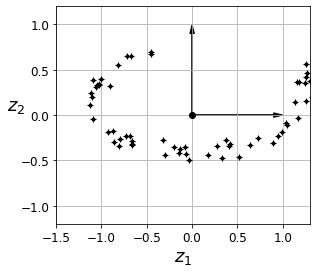

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

## Manifold Learning

In some instances, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn such as the figure below:

<img src="images/chapter8/swissroll.png">

Simply projecting it onto a plane would squash the different layers on top of each other:

<img src="images/chapter8/rollprojection.png">

This is an example of a 2D *manifold*. a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In this case, d=2 and n=3: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called *Manifold Learning*. It relies on the *manifold assumption*, also called the *manifold hypothesis*, which states that high-dimensional datasets lie close to a much lower dimensional manifold.

The manifold assumption is often accompanied by another implicit assumption: the task at hand (classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.

## PCA 

*Principal Component Analysis* is by far the most popular dimensionality reduction algorithm. It first identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

### Preserving the Variance

Before projecting the training instance onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. For example, a simple 2D dataset is represented on the left, along with three different axes. On the right is the result of the projection of the dataset onto each of these axes. The projection onto the slid line preserves the maximum variance, while the other preserves less variance. So it would make sense to choose the first axis as it preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way of justifying this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the general idea behind PCA.

### Principle Components

PCA identifies the axis that accounts for the largest amount of variance in the training set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of the remaining variance. In the example, if our data had higher-dimensions, PCA would find as many orthogonal axes as the number of dimensions in the dataset. The ith axis is called the ith principal component (PC) of the data.

To find the principal components of a training set, we can use a standard matrix factorization called Singular Value Decomposition (SVD) that can decompose the training set matrix X into the matrix multiplication of three matrices $\mathbf{U\sum V^T}$, where V  contains the unit vectors that define all principal components that we are looking for.

In [13]:
#3D data
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD

In [14]:
#PCA assumes that the dataset is centered around the origin.
#Scikit-Learn PCA does the centering for you, however if you implement PCA yourself, don't forget to center the data
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
#extracts the two unit vectors that define the first two PCs
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [15]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [18]:
#Projecting down to d dimensions
#Once you have identified all the principle components, you can reduce the dimensionality of the dataset down to d dimensions 
#by projecting it onto the hyperplane defined by the first d principal components
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)


X2D_using_svd = X2D

## Using Scikit-Learn

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [20]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [21]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [22]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [23]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [24]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [25]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [26]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [27]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

We can see the principle components that it computed:

In [29]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [30]:
#pc of SVD method
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

The explained variance ratio of each Principal Component indicates the proportion of the dataset's variance that lies along each principal component.

In [31]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The output tells us that 84.2% of the dataset's variance lies along the first PC, and 14.6% lies along the second PC, which leaves 1.2% for the third PC.

## Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose te number of dimensions that add up to a sufficiently large portion of the variance (e.g 95%). Unless you need to visualize the data then (2-3).


## PCA for Compression

In [33]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [34]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [35]:
pca=PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [36]:
d

154

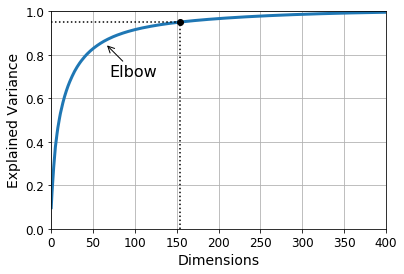

In [37]:

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

Preserving 95% of the variance will result in each instance to have over 150 features instead of the original 784 features. It is also possible to decompress the reduced dataset back to 784 dimension by applying the inverse transformation of the PCA projection. This won't give you back the original data, since the projection lost a bit of information, but it will likely be close to the original data. The mean squared distance between the original data and the reconstructed data is called the reconstruction error.

The following compresses the MNIST dataset down to 154 dimensions then we decompresses it back to 784 dimensions and plot the results:

In [38]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [39]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

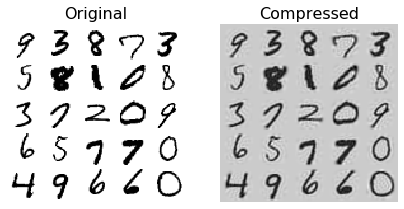

In [40]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)



## Randomized PCA

Setting the svd_solver parameter to "randomized" uses a stochastic algorithm called Randomized PCA that finds an approximation of the first d principal components. By default, svd_solver is set to "auto": it automatically usees the randomized PCA algorithm if m or n is greather than 500 and d is less than 80% of m or n, else it uses the full SVD approach. You can force Sklearn to use full SVD by setting the parameter to "full".

In [41]:
rnd_pca = PCA(n_components = 154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

One issue withe preceding methods and implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Using Incremental PCA, we can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time, which is useful for large training sets.

In [43]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [44]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

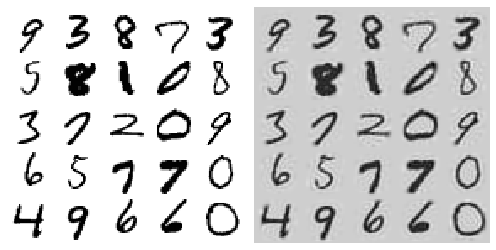

In [45]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

## Using memmap

Let's create the memmap() structure and copy the MNIST data into it. This would typically be done by a first program:

In [46]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [47]:
del X_mm

In [48]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [49]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Time Complexity

Let's examine the run times of regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [50]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 1.2 seconds
    IncrementalPCA: 7.6 seconds
    PCA: 1.3 seconds
n_components = 10
    PCA: 1.3 seconds
    IncrementalPCA: 7.3 seconds
    PCA: 1.3 seconds
n_components = 154
    PCA: 3.6 seconds
    IncrementalPCA: 10.0 seconds
    PCA: 3.5 seconds


In [ ]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

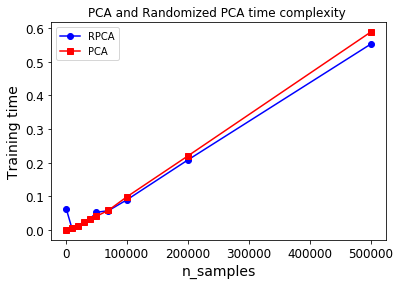

In [51]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")


And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

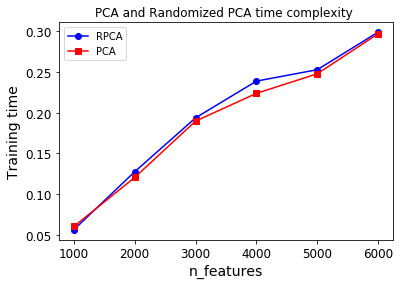

In [52]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## Kernel PCA

The kernel trick in chapter 5, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with SVMs. A linear decision boundary in the high dimensional feature space corresponds to a complex nonlinear decision boundary in the original space.

We can apply the same trick to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This iscaled Kernel PCA (kPCA).

The following code uses Scikit-Learn's KernelPCA class to perform kPCA with an RBF kernel:

In [54]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [55]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

The following figure shows the swiss roll, reduced to two dimensions using a linear kernel,  an RBF kernel, and a sigmoid kernel

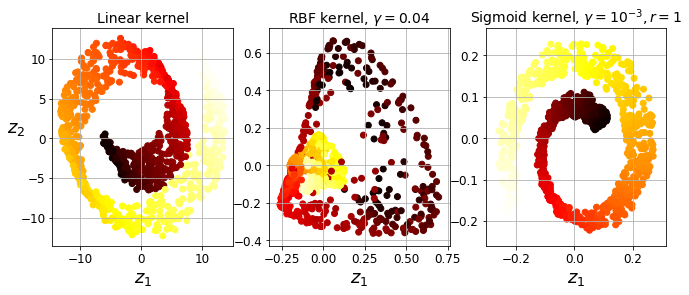

In [56]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)


plt.show()

kPCA by itself is an unsupervised learning algorithm, so there is no obvious performance measure to use to select the best kernel and hyperparameter values. However, since dimensionality reduction is often a preparation step for supervised learning, you can utilize grid search to help select the optimal kernel and hyperparameters that lead to the best performance for a given dataset.

The following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA, the applying Logistic Regression for classification. Then it uses GridSearchCV to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

In [58]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Another approach is to select the kernel and hyperparameters that yield the lowest reconstruction error.

<img src="images/chapter8/reconstruction.png">

However this could be difficult. The figure above shows the original dataset (top left) and the resulting 2D dataset after kPCA (top right) using RBF kernel. Using the kernel trick, the transformation is equivalent to using the feature map to map the training set to an infinite-dimensional feature space (bottom right), rather than projecting the transformed trianing set down to 2D using linear PCA.

If we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would line in the feature space, not the original space. Since the feature space is infinite-dimensional, we cannot compute the reconstructed point. However it is possible to find a point in the original space that would map close to the reconstructed point. This point is referred to as the reconstruction pre-image. Once you have this pre-image, you can measure its squared distance to the original instance. It is then possible to select the kernel and hyperparameters that minimize this reconstruction pre-image error.

In [59]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [60]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576611

Now we can utilize grid search with cross-validation to find the kernel and hyperparameters that minimize this error.

## LLE 

Locally Linear Embedding is another powerful nonlinear dimensionality reduction technique. It is a Manifold Learning technique that does not rely on projections, like the previous algorithms do. LLE works by first measuring how each training instance linearly relates to its closest neighborsm and then looking for a low-dimensional representation of the training set where these local relationships are best preserved. This approach makes it effective at dealing with twisted and rolling manifolds, especially when there is not too much noise.

In [61]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [62]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

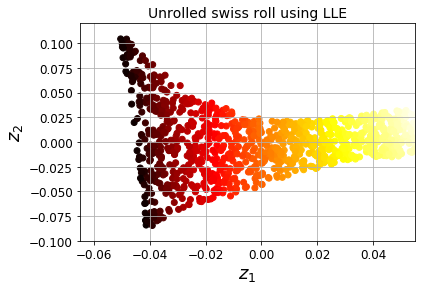

In [63]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)


plt.show()

The resulting 2D dataset shows that the roll is completely unrolled and the distances between instances are locally well preserved. However distances are not preserved on a larger scale: the left part is stretched, while the right part is squeezed.

How it works:

for each training instance $x^{(i)}$, the algorithm identifies its k closest neighbors then tries to reconstruct $x^{(i)}$ as a linear function of these neighbors (it finds the weights, $w_{i,j}$, such that the squared distance between $x^{(i)}$ and $\sum_{j=1}^m w_{i,j}$ is as small as possible).

After that, the weight matrix $\hat{\mathbf{w}}$ encodes the local linear relationships between the training instances. The second step is to map the training instance into a d-dimensional space (where d < n) whle preserving these local relationships as much as possible. If $z^{(i)}$ is the image of $x^{(i)}$ in this d-dimensional space, then we want the squared distance between $z^{(i)}$ and $\sum_{j=1}^m w_{i,j}z^{(j)}$ to be as small as possible.

## Other Dimensionality Reduction Techniques

*Multidimensional Scaling (MDS)*: \
Reduces dimensionality while trying to preserve distances between instances.
\
\
*Isomap*:\
Creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances.\
\
*t-Distributed Stochastic Neighbor Embedding (t-SNE)*:\
Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space
\
\
*Linear Discriminant Analysis*:\
a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.

In [64]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [65]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\Users\Abraham Lin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
